In [1]:
import sys
from ast import literal_eval
import math
import random as rd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import keras
from tensorflow.python.framework import ops
from keras.models import Model,Sequential, load_model
from keras.applications.inception_resnet_v2 import InceptionResNetV2#, preprocess_input
# from keras.applications import MobileNet
# from keras.applications.mobilenet import preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.layers import Dropout, Dense, Flatten, Input, Activation
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils as u
from keras import optimizers
from sklearn.metrics import f1_score
from statistics import mean,stdev
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def choose_model(model_name):
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (2,2), padding = 'same', activation = 'relu', input_shape = (6,6,1)))
    model.add(Conv2D(32, kernel_size = (2,2), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size = (2,2), padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, kernel_size = (2,2), padding = 'same', activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(1))
    return model

In [15]:
class DRL():

    def __init__(self):
        self.update_count = 1
        self.disc = 1.
        self.model1 = choose_model('cnn')
                
        self.model1.compile(optimizer = 'Adam', loss = 'mse')
        self.model2 = keras.models.clone_model(self.model1)
        
        
    def extractFeatures(self,state, action):

        feats = np.empty(0)
        board, piece = state
        x,y = action

#         #no of filled spots
#         feats = np.append(feats,np.count_nonzero(board))

#         def numOf2x2Spaces(board):
#             b = 0
#             count = 0
#             for i in range(len(board)-2):
#                 for j in range(len(board[0]-2)):
#                     if np.count_nonzero(board[i:i+2,j:j+2])==0:
#                         b = 1
#                         count += 1
#             return count, b

#         #num of places for 2x2 block
#         count, boo = numOf2x2Spaces(board)
#         feats = np.append(feats,count)
#         feats = np.append(feats,boo)

#         #no of pieces in rows, and indicator for cleared row
#         for i in range(len(board)):
#             count = np.count_nonzero(board[i])
#             if count==0:
#                 feats = np.append(feats,1)
#             else:
#                 feats = np.append(feats,0)
#             feats = np.append(feats,count)

#         #no of pieces in cols, and indicator for cleared col
#         for i in range(len(board[0])):
#             count = np.count_nonzero(board[:,i])
#             if count==0:
#                 feats = np.append(feats,1)
#             else:
#                 feats = np.append(feats,0)
#             feats = np.append(feats,count)

#         # # weighted sum of filled spots, with higher weights to the edges

#         # # almost filled columns and rows

#         # # no of empty rows and columns

#         # c = 0

#         for i in range(len(board)):
#             for j in range(len(board[0])):
#                 feats = np.append(feats, 1 if board[i,j] else 0)

#         for p in piecenames:
#             feats = np.append(feats, 1 if p==piece else 0)


#         for i in range(len(board)):
#             for j in range(len(board[0])):
#                 feats = np.append(feats, 1 if (x==i and y==j) else 0)

#         feats = np.append(feats, float(abs(2.5-x)+abs(2.5-y)))
#         #print(feats.shape)
#         return np.expand_dims(feats, axis=0)
    
    
        new_board = np.copy(board)
        arr = np.array(pieces[piece][0])
        h, w = arr.shape

        #place piece
        for i in range(h):
            for j in range(w):
                new_board[x+i,y+j] = arr[i,j] or new_board[x+i,y+j]

        #eliminate rows/cols

        cols_to_elim = []
        rows_to_elim = []

        for i in range(len(new_board)):
            if all(new_board[i]):
                rows_to_elim.append(i)

        for j in range(len(new_board[0])):
            if all(new_board[:,j]):
                cols_to_elim.append(j)

        for col in cols_to_elim:
            new_board[:,col] = np.full(len(new_board), False)

        for row in rows_to_elim:
            new_board[row] = np.full(len(new_board[0]), False)
        
        return_board = new_board        
        for i in range(len(new_board)):
            for j in range(len(new_board[0])):
                return_board[i,j] = 1 if new_board[i,j] else 0
     
        return np.expand_dims(np.expand_dims(return_board, axis=0),axis=3)

    def chooseAction(self,state,actions):

        eps = 0.99995**self.update_count/10
        #action = (x,y)
        best_q = None
        best_action = None

        for action in actions:
            feats = agent.extractFeatures(state,action)
            #print(feats.size)
            q = self.model2.predict(feats)
#             print(q.shape)
            if best_action is None or q[0,0]>best_q:
                best_action = action
                best_q = q[0,0]
                
        randint = np.random.random()
        
        b_a = None
        
        if randint < eps:
            b_a = rd.choice(actions)
        else:
            b_a = best_action
        
        #print('Action: '+str(b_a))
        return b_a

    def updateWeights(self, state, action, reward, next_state):
        if self.update_count % 5000 == 0:
            print(self.update_count)
            self.model2.set_weights(self.model1.get_weights()) 
        feats = agent.extractFeatures(state,action)
        board, piece = state
        next_board, next_piece = next_state
        n_s_poss_actions = availableIndices(next_board, next_piece)
        approx = self.model2.predict(feats)
        if len(n_s_poss_actions)==0:
            v_opt = 0
        else:
            v_opt = max([self.model2.predict(agent.extractFeatures(next_state,new_action))for new_action in n_s_poss_actions])
        target = reward + self.disc*v_opt
        target_arr = np.zeros(1)
        target_arr[0]=target
        self.model1.fit(feats, target_arr, verbose = 0)
        self.update_count += 1

In [16]:
pieces = {

    '3-block-h': ([[1,1,1]], 3, 1./10),

    '2-block-h': ([[1,1]], 2, 1./10),

    '1-block-h': ([[1]], 1, 1./10),

    '3-block-v': ([[1],[1],[1]], 3, 1./10),

    '2-block-v': ([[1],[1]], 2, 1./10),

    'l-2-a': ([[1,0],[1,1]], 3, 1./10),

    'l-2-b': ([[0,1],[1,1]], 3, 1./10),

    'l-2-c': ([[1,1],[0,1]], 3, 1./10),

    'l-2-d': ([[1,1],[1,0]], 3, 1./10),

    '2-square': ([[1,1],[1,1]], 4, 1./10),

    }

piecelist = list(pieces.items())
piecenames = [piece[0] for piece in piecelist]
pieceprobs = [piece[1][2] for piece in piecelist]

In [17]:
def availableIndices(board, piece):
    indices = []
    arr = np.array(pieces[piece][0])
    h, w = arr.shape
    for i in range(len(board)-h+1):
        for j in range(len(board[0])-w+1):
            if np.all(np.logical_not(np.logical_and(board[i:i+h,j:j+w],arr))): #if all of the entries are false:
                indices.append((i,j))
    return indices

In [18]:
def pickMove(board, piece, indices):
    state = (board,piece)
    return agent.chooseAction(state,indices)


In [19]:
def show_board(board):
    print(' ', '_ ' * 6)
    for i in range(board.shape[0]):
        print('|', end='')
        for j in range(board.shape[1]):
            if board[i, j]:
                print('*', end=' ')
            else:
                print(' ', end=' ')
        print(' |')
    print(' ', '_ ' * 6)

In [20]:
def playGame(k):

    board = np.full((6,6), False)
    score = 0

    piece = np.random.choice(piecenames,p=pieceprobs)

    while True:
        
#         if k%100==1:
#             show_board(board)
#             print ('piece: '+ piece)
#             print ("score: " + str(score))

        indices = availableIndices(board,piece)
        if len(indices)==0:
            break

        arr = np.array(pieces[piece][0])
        h, w = arr.shape
        #ask user for entry index, until valid index is input

        x,y = pickMove(board, piece, indices)

        new_board = np.copy(board)

        #place piece
        for i in range(h):
            for j in range(w):
                new_board[x+i,y+j] = arr[i,j] or new_board[x+i,y+j]

        #eliminate rows/cols

        cols_to_elim = []
        rows_to_elim = []

        for i in range(len(new_board)):
            if all(new_board[i]):
                rows_to_elim.append(i)

        for j in range(len(new_board[0])):
            if all(new_board[:,j]):
                cols_to_elim.append(j)

        for col in cols_to_elim:
            new_board[:,col] = np.full(len(new_board), False)

        for row in rows_to_elim:
            new_board[row] = np.full(len(new_board[0]), False)

        #update score, randomly pick new piece

        new_score = score + (5+5*(len(rows_to_elim)+len(cols_to_elim)))*(len(rows_to_elim)+len(cols_to_elim))+pieces[piece][1]

        #name = input("press enter for next step")

        new_piece = np.random.choice(piecenames,p=pieceprobs)

        agent.updateWeights((board,piece), (x,y), new_score - score, (new_board,new_piece))

        score = new_score
        piece = new_piece
        board = new_board


    return score

In [ ]:
agent = DRL()

max_score = float('-inf')
scores = []

s = 0.
for k in range(1,10001):
    if k%10==0:
        print('Game '+ str(k)+', average score: '+str(s/10))
        s=0.
    game_score = playGame(k)
    scores.append(game_score)
    if agent.update_count>5000 and game_score > max_score:
        max_score = game_score
    s += game_score
#     if agent.update_count>30000:
#         break


In [22]:
print(max_score)
print(scores)

3815
[54, 43, 27, 129, 24, 21, 42, 126, 301, 95, 50, 254, 132, 118, 68, 117, 130, 40, 71, 179, 38, 171, 38, 105, 161, 170, 97, 71, 134, 40, 72, 139, 59, 173, 101, 153, 85, 120, 24, 71, 68, 51, 115, 26, 143, 146, 53, 160, 74, 82, 39, 40, 111, 171, 215, 28, 40, 127, 38, 220, 218, 91, 86, 103, 23, 57, 80, 56, 174, 154, 158, 178, 21, 393, 47, 53, 105, 146, 135, 57, 135, 115, 80, 54, 136, 133, 201, 23, 22, 78, 123, 148, 96, 23, 306, 42, 141, 353, 273, 88, 143, 207, 25, 142, 53, 186, 65, 88, 319, 38, 53, 111, 37, 153, 35, 82, 36, 20, 212, 38, 69, 261, 104, 67, 191, 85, 74, 83, 185, 133, 110, 141, 55, 39, 89, 56, 268, 56, 56, 41, 87, 21, 39, 38, 36, 53, 80, 87, 84, 184, 37, 72, 24, 151, 158, 234, 114, 21, 174, 44, 75, 37, 131, 156, 27, 162, 108, 36, 54, 174, 57, 99, 39, 86, 69, 40, 217, 252, 266, 199, 120, 81, 193, 50, 112, 73, 207, 69, 53, 22, 191, 56, 198, 57, 304, 88, 185, 94, 56, 81, 229, 242, 39, 39, 84, 84, 83, 54, 136, 116, 51, 91, 25, 68, 125, 112, 208, 320, 114, 185, 184, 121, 56, 10

In [23]:
agent.model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 6, 6, 32)          160       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 64)          8256      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 3, 3, 64)          16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
__________

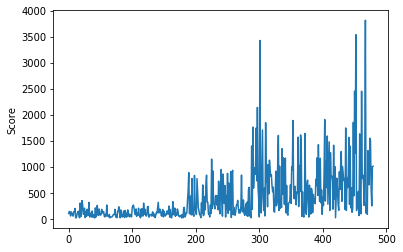

In [24]:
plt.plot(scores[76:])
plt.ylabel('Score')
plt.show()


In [25]:
from numpy import convolve
import matplotlib.pyplot as plt
 
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

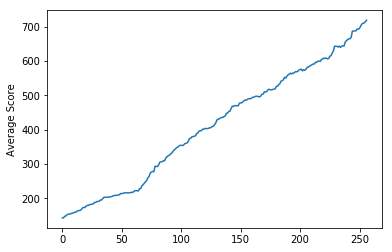

In [26]:
ma = movingaverage(scores[100:],200)
plt.plot(ma)
plt.ylabel('Average Score')
plt.show()

In [ ]:
print(scores)